## Introduzione

**Parte uno**: recupero i dati, runno il file di Sho per trovarmi il dataset con tutti i dati

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd
import json
from shapely.geometry import Point, shape, Polygon, MultiPolygon, MultiPoint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime
import pickle
import numpy as np
from shapely.ops import nearest_points
data_path = Path('data')

In [3]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',
        'weather':'meteotrentino-weather-station-data.json',
        'precip':'precipitation-trentino.csv',
        'precip-avail':'precipitation-trentino-data-availability.csv',
        'SET-1':'SET-nov-2013.csv',
        'SET-2':'SET-dec-2013.csv',
        'SET-lines':'line.csv',
        'twitter':'social-pulse-trentino.geojson'}

def load_data(path):
    set1 = pd.read_csv(path / files['SET-1'], names = ['LINESET', 'TIMESTAMP', 'POWER'])
    set2 = pd.read_csv(path / files['SET-2'], names = ['LINESET', 'TIMESTAMP', 'POWER'])
    lines = pd.read_csv(path / files['SET-lines'])
    precip = pd.read_csv(path / files['precip'], names = ['TIMESTAMP','CELL_ID', 'INTENSITA'])
    precip_avail = pd.read_csv(path / files['precip-avail'], names = ['TIMESTAMP', 'AFFIDABILE'])
    with open(path / files['weather']) as f:
        meteo_json = json.load(f)
    meteo = gpd.GeoDataFrame(meteo_json['features'])
    meteo['geometry'] = meteo['geomPoint.geom'].apply(lambda x: Point(x['coordinates'][0], x['coordinates'][1]))
    meteo.drop(columns=['geomPoint.geom'], inplace=True)
    grid = gpd.read_file(path / files['grid'])
    with open(path / files['twitter']) as f:
        tweets_json = json.load(f)
    tweets = gpd.GeoDataFrame(tweets_json['features'])
    tweets['geometry'] = tweets['geomPoint.geom'].apply(lambda x: Point(x['coordinates'][0], x['coordinates'][1]))
    tweets.drop(columns=['geomPoint.geom'], inplace=True)
    with open(path / files['adm_reg']) as f:
        regions_json = json.load(f)
    regions = gpd.GeoDataFrame(regions_json['items'])
    localunits = pd.read_csv(path / 'localunits.csv')
    localunitworkers = pd.read_csv(path / 'localunitworkers.csv')
    return set1, set2, lines, precip, precip_avail, meteo, grid, tweets, regions, localunits, localunitworkers

In [5]:
set1, set2, lines, precip, precip_avail, meteo, grid, tweets, regions, lu, luw = load_data(data_path)
set_tot = pd.concat([set1, set2], ignore_index=True)

***EDA***

*Cerco territorio urbano di Trento*

In [6]:
with open('data/tn_adm.json') as f:
    adm_json = json.load(f)
    
for d in adm_json['features']:
    d['geometry'] = shape(d['geometry'])

In [7]:
adm_gdf = gpd.GeoDataFrame(adm_json['features'])
adm_gdf.plot()

Seleziono le cellId identificate come comune di Trento

In [8]:
trento = adm_gdf.loc[adm_gdf['properties'].apply(lambda row: row['name'] == 'Trento') == True]

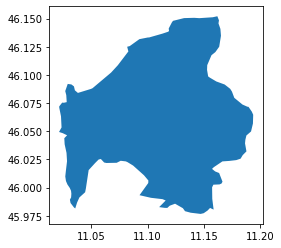

In [9]:
trento['geometry'].plot()

In [10]:
confini_trento = trento['geometry'].loc[142]

Mi recupero le coordinate di tutte le "celle" con i requisiti richiesti sopra

In [11]:
celle_giuste = grid.loc[(grid['geometry'].apply(lambda poligono: poligono.within(confini_trento) == True))]

In [12]:
celle_giuste

cellId                                           geometry
1620    4149  POLYGON ((11.13194 45.99318, 11.14484 45.99294...
1706    4264  POLYGON ((11.10647 46.00266, 11.11938 46.00242...
1707    4265  POLYGON ((11.11938 46.00242, 11.13228 46.00218...
1708    4266  POLYGON ((11.13228 46.00218, 11.14519 46.00194...
1789    4375  POLYGON ((11.02936 46.01305, 11.04227 46.01282...
...      ...                                                ...
3102    6020  POLYGON ((11.12455 46.13733, 11.13749 46.13709...
3103    6021  POLYGON ((11.13749 46.13709, 11.15043 46.13685...
3104    6022  POLYGON ((11.15043 46.13685, 11.16336 46.13660...
3207    6137  POLYGON ((11.12490 46.14632, 11.13784 46.14608...
3208    6138  POLYGON ((11.13784 46.14608, 11.15078 46.14584...

[119 rows x 2 columns]

*Cerco i dati dei consumi elettrici del trentino*

In [13]:
elett = [set1, set2]
elett = pd.concat(elett)

Divido il dataset in dati di giorno e di sera

In [14]:
def sistemaDataEOra (timestamp):
    month = int(timestamp[5:7])
    day = int(timestamp[8:10])
    hour = int(timestamp[11:13])
    
    fascia_oraria = 0
    
    if (month == 11):
        if (day % 7 != 3):
            if ((hour > 7) and (hour < 20)):
                fascia_oraria = 1
            elif(hour > 19):
                fascia_oraria = 2
            
    elif (month == 12):
        if (day % 7 != 1):
            if ((hour > 7) and (hour < 20)):
                fascia_oraria = 1
            elif(hour > 19):
                fascia_oraria = 2 
            
    return fascia_oraria

In [15]:
elett['fascia_oraria'] = elett['TIMESTAMP'].apply(sistemaDataEOra)
elett

LINESET         TIMESTAMP      POWER  fascia_oraria
0       DG1000420  2013-11-01 00:00  37.439999              0
1       DG1000420  2013-11-01 00:10  37.439999              0
2       DG1000420  2013-11-01 00:20  36.000000              0
3       DG1000420  2013-11-01 00:30  35.279999              0
4       DG1000420  2013-11-01 00:40  35.279999              0
...           ...               ...        ...            ...
821371  DG1056626  2013-12-31 23:10  79.574997              2
821372  DG1056626  2013-12-31 23:20  78.625000              2
821373  DG1056626  2013-12-31 23:30  77.025002              2
821374  DG1056626  2013-12-31 23:40  76.125000              2
821375  DG1056626  2013-12-31 23:50  75.775002              2

[1615894 rows x 4 columns]

In [16]:
cons_mattina = elett.loc[(elett['fascia_oraria'] == 1)]
cons_sera = elett.loc[(elett['fascia_oraria'] == 2)]

cons_mattina

LINESET         TIMESTAMP       POWER  fascia_oraria
48      DG1000420  2013-11-01 08:00   34.739998              1
49      DG1000420  2013-11-01 08:10   35.820000              1
50      DG1000420  2013-11-01 08:20   37.439999              1
51      DG1000420  2013-11-01 08:30   37.439999              1
52      DG1000420  2013-11-01 08:40   38.519997              1
...           ...               ...         ...            ...
821347  DG1056626  2013-12-31 19:10    0.000000              1
821348  DG1056626  2013-12-31 19:20    0.000000              1
821349  DG1056626  2013-12-31 19:30    0.000000              1
821350  DG1056626  2013-12-31 19:40  119.150002              1
821351  DG1056626  2013-12-31 19:50  117.175003              1

[688534 rows x 4 columns]

Proseguo ora trovando per ogni cellId la potenza normalizzata (visto in classe)

In [17]:
cons_matt = cons_mattina.groupby(['LINESET'])['POWER'].sum()
cons_ser = cons_sera.groupby(['LINESET'])['POWER'].sum()

cons_matt

LINESET
DG1000420    247085.929162
DG1000421    116041.315105
DG1000422    132197.094158
DG1000423     81691.136351
DG1000425    124343.034482
                 ...      
DG1056621    152168.524917
DG1056623     60095.791684
DG1056624    164421.899951
DG1056625    188448.483292
DG1056626    213087.108181
Name: POWER, Length: 184, dtype: float64

In [18]:
tot_ubic = lines.groupby(['LINESET'])['NR_UBICAZIONI'].sum()
tot_ubic

LINESET
DG1000011       6
DG1000023      62
DG1000420    2133
DG1000421    1424
DG1000422    3423
             ... 
DG1099206     105
DG1099207      95
DG1099303      39
DG1099502       3
DG1099506       1
Name: NR_UBICAZIONI, Length: 200, dtype: int64

In [19]:
con_mat = pd.merge(lines,cons_mattina,on='LINESET',how='inner',indicator=True)
con_sera = pd.merge(lines,cons_sera,on='LINESET',how='inner',indicator=True)

con_mat

SQUAREID    LINESET  NR_UBICAZIONI         TIMESTAMP       POWER  \
0             155  DG1031221              4  2013-11-01 08:00   26.160000   
1             155  DG1031221              4  2013-11-01 08:10   27.959999   
2             155  DG1031221              4  2013-11-01 08:20   26.039999   
3             155  DG1031221              4  2013-11-01 08:30   30.000000   
4             155  DG1031221              4  2013-11-01 08:40   26.039999   
...           ...        ...            ...               ...         ...   
9471019     10984  DG1013504              2  2013-12-31 19:10  129.975006   
9471020     10984  DG1013504              2  2013-12-31 19:20  127.949997   
9471021     10984  DG1013504              2  2013-12-31 19:30  132.675003   
9471022     10984  DG1013504              2  2013-12-31 19:40  129.699997   
9471023     10984  DG1013504              2  2013-12-31 19:50  128.750000   

         fascia_oraria _merge  
0                    1   both  
1                    1   both  
2                    1   both  
3                    1   both  
4                    1   both  
...                ...    ...  
9471019              1   both  
9471020              1   both  
9471021              1   both  
9471022              1   both  
9471023              1   both  

[9471024 rows x 7 columns]

In [ ]:
cm = pd.merge(con_mat, tot_ubic, on='LINESET',how='inner')
cs = pd.merge(con_sera, tot_ubic, on='LINESET',how='inner')

cm

In [ ]:
cm['POWER_CELLID'] = cm['POWER']* cm['NR_UBICAZIONI_x'] / cm['NR_UBICAZIONI_y']
cs['POWER_CELLID'] = cs['POWER']* cs['NR_UBICAZIONI_x'] / cs['NR_UBICAZIONI_y']

cm1 = cm.drop(columns = 'fascia_oraria', axis = 1)
cs1 = cs.drop(columns = 'fascia_oraria', axis = 1)

Bene, ora voglio avere un secondo discriminatore oltre al cellId, questo sarà dato dal giorno (mese-giorno visto che l'anno è uguale per tutti).
Per il dataset *total_datecell* è stata fatta un'altra manipolazione per riuscire ad usarlo come stringa

In [ ]:
def ottieniGiorno(timestamp):
    day = timestamp[5:10]
    
    return day


In [ ]:
def ottieniData(date):
    data = str(date)
    day = data[5:10]
    
    return data

In [ ]:
total_datecell['TIMESTAMP'] = total_datecell['date'].apply(ottieniData)

In [ ]:
total_datecell['day'] = total_datecell['TIMESTAMP'].apply(ottieniGiorno)

In [ ]:
total_datecell = total_datecell.drop(columns = ['TIMESTAMP', 'date'], axis = 1)

In [ ]:
total_datecell

In [ ]:
cm1['day'] = cm1['TIMESTAMP'].apply(ottieniGiorno)
cs1['day'] = cs1['TIMESTAMP'].apply(ottieniGiorno)

Usando ora i due discriminatori citati prima mi costruisco una tabella dove per ogni cellId è indicata la potenza giornaliera normalizzata

In [ ]:
cm2 = cm1.groupby(['SQUAREID', 'day'])['POWER_CELLID'].sum().reset_index()
cs2 = cs1.groupby(['SQUAREID', 'day'])['POWER_CELLID'].sum().reset_index()

In [ ]:
cm2

Con il seguente merge vado a selezionare tra le righe della tabella sopra quelle che hanno un cellId uguale a quello di una delle celle che descrivono il comune di trento

In [ ]:
cm10 = pd.merge(left = cm2, right = celle_giuste, how = 'inner', left_on = 'SQUAREID', right_on = 'cellId')
cs10 = pd.merge(left = cs2, right = celle_giuste, how = 'inner', left_on = 'SQUAREID', right_on = 'cellId')


cm10

Con questo secondo merge vado ad inserire anche i dati rigurdanti il meteo e twitter

In [ ]:
cm11 = pd.merge(left = cm10, right = total_datecell, how = 'inner', left_on = 'SQUAREID', right_on = 'cellId')
cs11 = pd.merge(left = cs10, right = total_datecell, how = 'inner', left_on = 'SQUAREID', right_on = 'cellId')

cm11

In [ ]:
cm3 = cm11.loc[cm11['day_x'] == cm11['day_y']]
cs3 = cs11.loc[cm11['day_x'] == cm11['day_y']]

cm3

Definisco il mio target: identifico i consumatori maggiori quelli che hanno una potenza di cella superiore alla mediana

In [ ]:
treshold_m = np.percentile(cm2['POWER_CELLID'], 50)
treshold_s = np.percentile(cs2['POWER_CELLID'], 50)

In [ ]:
cm3['target'] = np.where(cm3['POWER_CELLID'] >= treshold_m, 1, -1)
cs3['target'] = np.where(cs3['POWER_CELLID'] >= treshold_m, 1, -1)

cm3

Inizio a preparare definitivamente i miei dati perchè possano essere divisi in training e test

In [ ]:
cm4 = cm3.drop(columns = 'SQUAREID', axis = 1)
cs4 = cs3.drop(columns = 'SQUAREID', axis = 1)

cm4

*Divido nei set di test e di training*

In [ ]:
cm5 = cm4.drop(columns = ['geometry', 'day_y', 'day_x', 'cellId_y'], axis = 1)
cs5 = cs4.drop(columns = ['geometry', 'day_y', 'day_x', 'cellId_y'], axis = 1)

cm5

Faccio la scelta di sostituire i NaN con 0, l'informazione non viene perduta: se prima non sappiamo dire quanto sia, ora la mettiamo nulla

In [ ]:
cm5['tweetcount'] = cm5['tweetcount'].fillna(0)
cm5['mean_wind'] = cm5['mean_wind'].fillna(0)

cs5['tweetcount'] = cs5['tweetcount'].fillna(0)
cs5['mean_wind'] = cs5['mean_wind'].fillna(0)

cm5

**TRAINING E TEST**: divido nei due set per ogni dataset

In [ ]:
X_m = cm5.drop(columns = 'target', axis = 1)
y_m = cm5['target']

X_s = cs5.drop(columns = 'target', axis = 1)
y_s = cs5['target']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size = 0.2, shuffle = False)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = 0.2, shuffle = False)

Voglio capire se le mie feature sono tutte importanti e da cosa dipende maggiormente il 'fit'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()


def plot_feature_importance():
    clf.fit(X_train_m, y_train_m)
    tmp = pd.DataFrame({'Feature': ['POWER_CELLID','cellId_x', 'tweetcount', 'mean_prec', 'mean_wind', 'mean_temp'], 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()  

In [ ]:
plot_feature_importance()

In [ ]:
def plot_feature_importance_s():
    clf.fit(X_train_s, y_train_s)
    tmp = pd.DataFrame({'Feature': ['POWER_CELLID','cellId_x', 'tweetcount', 'mean_prec', 'mean_wind', 'mean_temp'], 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()  

In [ ]:
plot_feature_importance_s()

Si vede bene che il maggior contributo è dato dal valore di potenza

In [ ]:
#clf.score(X_train_m, y_train_m)
#acc = round(clf.score(X_train_m, y_train_m) * 100, 2)
#print("RandomForest accuracy (train set):", acc)

In [ ]:
#clf.score(X_test_m, y_test_m)
#acc = round(clf.score(X_test_m, y_test_m) * 100, 2)
#print("RandomForest accuracy (validation set):", acc)

In [ ]:
#predicted = clf.predict(X_test_m)
#confusion_matrix(predicted, y_test_m)

**CROSS VALIDATION**

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn import linear_model

In [ ]:
lasso = linear_model.Lasso()

In [ ]:
results_m = cross_validate(lasso, X_train_m, y_train_m)
results_s = cross_validate(lasso, X_train_s, y_train_s)

In [ ]:
results_m

*Vado a considerare diversi classificatori*

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier

In [ ]:
ridge = linear_model.RidgeClassifier(max_iter = 1000)
#clf = RandomForestClassifier(oob_score = True)
LRC = LogisticRegression(max_iter = 1000)
#neigh = KNeighborsClassifier()

*Li faccio allenare su i set di training*

In [ ]:
#clf_m = clf.fit(X_train_m, y_train_m)
ridge_m = ridge.fit(X_train_m, y_train_m)
LRC_m = LRC.fit(X_train_m, y_train_m)
#neigh_m = neigh.fit(X_train_m, y_train_m)

*Faccio le mie predizioni*

In [ ]:
#clf_pred_m = clf.predict(X_test_m)
ridge_pred_m = ridge.predict(X_test_m)
LRC_pred_m = LRC.predict(X_test_m)
#neigh_pred_m = neigh.predict(X_test_m)

*Valuto i miei classificatori*

In [ ]:
from sklearn.metrics import confusion_matrix

#a = confusion_matrix(y_test_m, clf_pred_m)
aa = confusion_matrix(y_test_m, ridge_pred_m)
aaa = confusion_matrix(y_test_m, LRC_pred_m)
#aaaa = confusion_matrix(y_test_m, neigh_pred_m)

[ aa, aaa]

Le classi sono evidentemente sbilanciate... i negativi sono sempre in numero preponderante --> è meglio usare la PREC-REC curve

I due blocchi sono da fare per tutti i classificatori (poi per la sera)

**Nota:**clf e neigh non hanno attributo 'decision_function'. Clf usa oob_decision_function

In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_m, ridge.decision_function(X_test_m))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(ridge, X_test_m, y_test_m)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

Ripetiamo la procedura per gli altri due classificatori

In [ ]:
average_precision = average_precision_score(y_test_m, LRC.decision_function(X_test_m))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(LRC, X_test_m, y_test_m)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [ ]:
#clf_res_m = clf.score(X_test_m, y_test_m)
#ridge_res_m = ridge.score(X_test_m, y_test_m)
#LRC_res_m = LRC.score(X_test_m, y_test_m)
#neigh_res_m = neigh.score(X_test_m, y_test_m)

In [ ]:
#[clf_res_m, ridge_res_m, LRC_res_m, neigh_res_m]

*Ripeto per i set di dati riferiti alla sera*

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier

In [ ]:
ridge = linear_model.RidgeClassifier(max_iter = 1000)
#clf = RandomForestClassifier()
LRC = LogisticRegression(max_iter = 1000)
#neigh = KNeighborsClassifier()

In [ ]:
#clf_s = clf.fit(X_train_s, y_train_s)
ridge_s = ridge.fit(X_train_s, y_train_s)
LRC_s = LRC.fit(X_train_s, y_train_s)
#neigh_s = neigh.fit(X_train_s, y_train_s)

In [ ]:
#clf_pred_s = clf.predict(X_test_s)
ridge_pred_s = ridge.predict(X_test_s)
LRC_pred_s = LRC.predict(X_test_s)
#neigh_pred_s = neigh.predict(X_test_s)

In [ ]:
from sklearn.metrics import confusion_matrix

#b = confusion_matrix(y_test_s, clf_pred_s)
bb = confusion_matrix(y_test_s, ridge_pred_s)
bbb = confusion_matrix(y_test_s, LRC_pred_s)
#bbbb = confusion_matrix(y_test_s, neigh_pred_s)

[bb, bbb]

In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_s, ridge.decision_function(X_test_s))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(ridge, X_test_m, y_test_m)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [ ]:
average_precision = average_precision_score(y_test_s, LRC.decision_function(X_test_s))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(LRC, X_test_m, y_test_m)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [ ]:
#clf_res_s = clf.score(X_test_s, y_test_s)
#ridge_res_s = ridge.score(X_test_s, y_test_s)
#LRC_res_s = LRC.score(X_test_s, y_test_s)
#neigh_res_s = neigh.score(X_test_s, y_test_s)

In [ ]:
#[clf_res_s, ridge_res_s, LRC_res_s, neigh_res_s]

Per l'analisi fatta mi sembra inutile la cross validation (spero di non essermi perso niente).
Dei risultati vengono. Sono le 3:30, domani cerco di svegliarmi e riguardo

**COMMENTI:**
La Logistic Regression ci dà un valore di precisione pari al 100%: questo perchè sta facendo il procedimento inverso rispetto a quello che abbiamo fatto noi, ovvero sta andando a trovare la treshold che noi abbiamo dato all'inizio.